## <b> Word of caution </b>
This notebook is neither clean nor consistent, stemming not only from my limited experience with Jupyter notebooks but also from a <b>strong underlying reason</b>. There are two conflicting tasks.
1. I should create notebook that defines some problem, provides some insights based on data and ends up with some conclusions. That's what I tried to do, but this work is interrupted by:
2. I need to follow instructions to showcase my ability to deal with various technicalities, even if they are not at all necessary, or straigh forward against logic that flows from problem.

I am writing and designing software for 13 years. Code is there to solve some user problem, not to show off cool coding techniques... I am striving for this here, therefore in some cases I'm just igonring second goal... but still trying to show, that, yes I can do complex code if required.

Before submitting this to any business or manager I'd remove most of the code from the middle part, just leaving problem statement, crucial pieces of data analysis, best model, and summary. Current version is too long and too full of irrelevant technical details to have good presentational value.

Peer review and validation of math and domain specific assumptions is mandatory.


# **Malaria Detection**

##<b>Problem Definition</b>

**The context:** Why is this problem important to solve?<br>
- Malaria is a widespread issue negatively affecting a large part of the human population. At the same time, it is not easy to detect, as it may be carried without external symptoms for months while slowly developing into a more dangerous form. One crucial factor to consider is that it's mostly widespread in parts of the globe with a relatively low level of healthcare development, meaning there is not much educated medical personnel.
- While we can't address all issues related to malaria (such as treatment, access to drugs, and sample collection), there is one area where AI can significantly contribute: <b>sample analysis</b>.
- If we could develop an algorithm that identifies blood cells indicative of the presence of malaria, we could significantly reduce the cost of tests, and making detection a standard test would allow for earlier detection and treatment, which could make therapy cheaper and more effective.
- urthermore, it would reduce the cycle - mosquitoes become carriers of malaria after biting humans affected by it, and then they bite other humans, spreading the disease. If the average human was treated earlier, they would infect fewer mosquitoes, and those mosquitoes would infect fewer humans, resulting in less malaria overall.
- Furthermore, money isn't the only problem. It is not feasible to quickly train a large amount of medical personnel to detect malaria in blood cells. The human way isn't scalable by the very nature of how long it takes to train a person.
- There is also a question of inconsistency in human validations. It's not that every human technician will judge the same samples in the same way, so it's not impossible that AI could do a better job than the average human technician, and most probably, it would do it more consistently.
- The final dream of fighting malaria is having a machine that takes in a blood sample and prints out a simple yes/no statement about the presence of malaria. This is beyond the scope of the initial task, but the initial task is an enabler. If it works, the final dream is achievable. A single such machine could probably do the job of dozens of highly educated personnel.
- There are, of course, ethical questions about sharing highly sensitive private information, but that's relatively easy to mitigate by anonymizing samples before sending them and applying some encoding algorithms. It's a standard and known problem, so it's relatively easy to solve.

**State of affairs:** How is malaria detected presently?<br>
1. Clinical diagnosis - observing clinical symptoms and patient history. But it's highly nonspecific and it usually may work as initial judgments to perform some more specific tests. Malaria may cause symptoms similar to many other health issues and for a very long time, it may be present without any symptoms.
2. Serology - detecting antibodies. It is not very good for finding out if someone currently has malaria. It may be a result of a past infection.
3. Molecular methods (PCR) - state of the art, the best we have, but requires sophisticated laboratory facilities and highly skilled personnel. Unfortunately, it's not achievable for most of the human population and there seems to be no way to scale it.
4. Microscopic Examination of Blood Smears - requires smearing a blood sample and examining it through a microscope. It is highly specific but requires a skilled technician and is time-consuming.
5. Rapid Diagnostic Tests (RDTs) - immunochromatographic tests that detect specific antigens. They may return true results for past infections and aren't as sensitive compared to Microscopic Examination.
- <b>Summary:</b> Microscopic Examination is the gold standard. Using digital microscopes, we can automate the analysis part. If applied at scale and using non-profit funding to offset initial infrastructure and research costs, it could cost cents for analyzing a single sample, so it could be applied automatically with every case where Microscopic Examination is applied (e.g., detecting Anemia, Leukemia, Babesiosis, etc. - this is a really standard procedure). It's important to note that <b>Microscopic Analysis sensitivity (recall) is estimated in the range of 75%-95% depending on technician skill, sample quality, and parasite density, while specificity (accuracy) is often reported to be above 95%</b>.

**The objectives:** What is the intended goal?<br>
- The final dream can be achieved in steps. The first step is to create a simple web service that takes in pictures, applies a computer vision algorithm to them, and sends out a response about the presence of malaria. This would still be extremely useful and helpful. Simple computers and internet connections are available everywhere.
- Uploading an image is no problem, digital microscopes are popular. So we have all the pieces to integrate a system for image analysis, except for making the picture, but this is a standard procedure for various tests.
- There is a problem of "how to make it cheap, easy, and scalable," so some tools for automating making pictures of blood samples and sending them. But it's not part of the initial task. And let's keep in mind that Microscope Analysis is a standard procedure so we would plug into existing methodologies.
- There is a problem of "how to divide such a picture where there are thousands of cells" into single cells so they can be analyzed, but this is also not part of the initial task and it's a known problem that shouldn't be difficult to solve.

**The key questions:** What are the key questions that need to be answered?<br>
- Can we consistently detect cells that are symptomatic of malaria at a level comparable or better than traditional Microscopic Analysis?
- How to translate accuracy and recall of predictions on a single cell to specificity and sensitivity on the analysis of whole sample?

**The problem formulation:** What is it that we are trying to solve using data science?
- Here, we will do a technical feasibility study if such a project can be done using computer vision.
- The initial task is highly focused on: <b>Can we differentiate a cell affected by malaria from a healthy cell using computer vision with high accuracy and recall?</b>




**TECHNICAL NOTE**

Since this is a school project, it includes code that may not be necessary for a real-world study. This is to demonstrate my ability to tackle tasks, which are irrelevant to the central question of this project.

### <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>

## <b>Prepare drive and libraries</b>

###<b> Mount the Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import glob
from collections import Counter
import cv2
from tqdm import tqdm
import random
import h5py
from sklearn.utils import shuffle
import matplotlib.colors as mcolors

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, ReLU, LeakyReLU, PReLU, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.applications import VGG16
import json

### <b>Preparing tools</b>
Here are various functions and variables used multiple times later in code. Defining them upfront they can be compiled in one place, and their definitions doesn't intterrupt logic of project and finally this call can be run to allow running multiple sections independently (as running everything step by stap is painfully slow, especially considering not so uncommon interruptions in backend service provided by Google)

In [4]:
project_path = "/content/drive/MyDrive/projects/school/Capstone Project/"
test_data_folder = project_path + "data/cell_images/test/"
train_data_folder = project_path + "data/cell_images/train/"
test_data_path_high_res = project_path + "test_data.hdf5"
train_data_path_high_res = project_path + "training_data.hdf5"
test_data_file_8x8 = project_path + "test_data_8x8.npz"
train_data_file_8x8 = project_path + "train_data_8x8.npz"
infected = "parasitized"
healthy = "uninfected"


# No more used, I played with it, but results were very poor
def read_data_8x8(npz_file_path):
    """ Load images and labels of 8x8 format """
    with np.load(npz_file_path) as data:
        images = data['images']
        labels = data['labels']
    return images, labels


# Helper to get labels from given data set
def read_labels_high_res(file_path):
  with h5py.File(file_path, 'r') as hf:
    labels = np.array(hf['labels'])
  return labels


# Helper to get images from given data set
def read_images_high_res(file_path):
    with h5py.File(file_path, 'r') as hf:
        images = np.array(hf['images'])
    return images


def set_random_seeds():
  """Sets the seeds for numpy and tensorflow"""
  destiny = 44
  random.seed(destiny)
  np.random.seed(destiny)
  tf.random.set_seed(destiny)


def model_file_path(model_name):
  return os.path.join(project_path, f"{model_name}.keras")


def model_history_file_path(model_name):
  return os.path.join(project_path, f"{model_name}_history.json")


def save_history(history, model_name):
  path = model_history_file_path(model_name)
  with open(path, 'w') as history_file:
      json.dump(history.history, history_file)
  print(f"Training history saved to {path}")


# Reads history from file
def read_history(model_name):
  path = model_history_file_path(model_name)
  with open(path, 'r') as f:
    history = json.load(f)
  return history


def plot_accuracy(model_name):
  """Plots training and validation accuracy from model history"""
  model_history = read_history(model_name)
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
  plt.title('Training and Validation Accuracies')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()


def show_confusion(true, predicted):
  """Plots confusion matrix for classification results"""
  cm = confusion_matrix(true, predicted)
  classes = ['Healthy', 'Infected']
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()


# I print only accuracy as on research stage it doesn't matter what is sensitivity and specificyt
# When building final model we'd need to carefully tweak them with respect to domain requirements
# But it's relatively easy by adjusting threshold value
def predictions(model_name, test_images, test_labels):
  """Simple function to run predict on the saved model and binarize output"""
  predictor = load_model(model_file_path(model_name))
  _, test_acc, test_auc = predictor.evaluate(test_images, test_labels, verbose=0)
  print(f'Test accuracy: {test_acc}')
  predictions = predictor.predict(test_images)
  return np.where(predictions > 0.5, 1, 0)


def compile_and_fit_model(model, model_name, images, labels, validation_split=0.25, epochs=25, batch_size=512, learning_rate=0.001):
  """Helper function to run all the models to avoid copy-pasting code"""
  set_random_seeds() # to ensure reproductability
  model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy', tf.keras.metrics.AUC()]
  )
  model_path = model_file_path(model_name)
  history = model.fit(
    images, labels,
    validation_split = validation_split,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
        ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
  save_history(history, model_name)
  return history

## <b> Prepare the data </b>

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [5]:
data_folder = project_path + "data"
# The assumption is that there won't be new data, so once extracted to persistent storage
# I won't perform this again - therefore I'm not checking if content is full and up to date
if not os.path.exists(data_folder):
  os.makedirs(data_folder)
  with zipfile.ZipFile(project_path + "cell_images.zip", 'r') as zip_ref:
    zip_ref.extractall(data_folder)

In [6]:
# Checking if data was unzipped sucessfully and we have all images as expected
def get_files_recursively(folder_path):
  all_items = glob.glob(os.path.join(folder_path, '**', '*'), recursive=True)
  return [item for item in all_items if os.path.isfile(item)]

def check_n_of_files(expected_n_of_files, folder):
  actual_n_of_files = len(get_files_recursively(folder))
  print(f"[{actual_n_of_files == expected_n_of_files}] - there are {actual_n_of_files} in {folder}")

check_n_of_files(24958, train_data_folder)
check_n_of_files(2600, test_data_folder)

[True] - there are 24958 in /content/drive/MyDrive/projects/school/Capstone Project/data/cell_images/train/
[True] - there are 2600 in /content/drive/MyDrive/projects/school/Capstone Project/data/cell_images/test/


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
# First let's see what are the resolutions of images and if they all consist the same number of layers
def get_image_properties(files):
  properties_list = []
  for file_path in files:
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    height, width, channels = image.shape
    extension = os.path.splitext(file_path)[1]  # File extension
    properties = (width, height, channels, extension)
    properties_list.append(properties)
  return properties_list

image_properties = get_image_properties(get_files_recursively(data_folder))

In [ ]:
# Check if each is .png and has 3 layers
files_with_different_n_of_layers = 0
files_in_different_format = 0
for img_props in image_properties:
  if img_props[2] != 3:
    files_with_different_n_of_layers += 1
  if img_props[3] != '.png':
    files_in_different_format += 1
print(f"There are {files_with_different_n_of_layers} files with different number of layers")
print(f"There are {files_in_different_format} files in non .png format")

There are 0 files with different number of layers
There are 0 files in non .png format


###<b> Check the shape of train and test images

In [ ]:
# Now it's confirmed that they are all .png images with 3 layers, let's check their sizes
images_below_64 = 0
images_below_128 = 0
images_below_256 = 0
images_above_256 = 0
for width, height, _, _ in image_properties:
  if min(width, height) < 64:
    images_below_64 += 1
  elif min(width, height) < 128:
    images_below_128 += 1
  elif min(width, height) < 256:
    images_below_256 += 1
  else:
    images_above_256 += 1
print(f"{images_below_64} images are below 64x64 pixels")
print(f"{images_below_128} images are between 64x64 and 128x128 pixels")
print(f"{images_below_256} images are between 128x128 and 256x256 pixels")
print(f"{images_above_256} images are above 256x256 pixels")

20 images are below 64x64 pixels
16178 images are between 64x64 and 128x128 pixels
11357 images are between 128x128 and 256x256 pixels
3 images are above 256x256 pixels


###<b> Check the shape of train and test labels </b>
There are no labels given - I'll generate them when preparing data, so this point is invalid for this data. Yes - I need to check how many there are images in each set to see if it's balanced but it's mentioned later and I'm not yet done with preprocessing data.

In [ ]:
# inapporapriate for this data

####<b> Observations and insights:
Images have very different sizes and aspects ratio. Taking into consideration their distribution I'll convert them to uniform size of 64x64 pixels what is still reasonable. Quite maybe lower resolution like 32x32 would be good enough but given the goal of this task we are to check if accurate classification is possible, not focus on opitimizing performance and computational cost, so starting with higer resolution is most reasonable approach.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
def check_pixel_value_ranges(folder, data_title):
  file_paths = get_files_recursively(folder)
  min_val, max_val = 255, 0  # Initialize to opposite extremes
  for file_path in file_paths:
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, expand_animations=False)
    min_val = min(min_val, tf.reduce_min(img))
    max_val = max(max_val, tf.reduce_max(img))
  print(f"{data_title} pixel values are in range: {min_val.numpy()} - {max_val.numpy()}")

check_pixel_value_ranges(train_data_folder, "Training data")
check_pixel_value_ranges(test_data_folder, "Test data")

Training data pixel values are in range: 0 - 255
Test data pixel values are in range: 0 - 255


####<b> Observations and insights:
It's confirmed that .png files are according to specification and pixel values are encoded 8bits per channel.



###<b> Count the number of values in both uninfected and parasitized

In [ ]:
def print_data_balance(data_folder, data_title):
  infected_images = len(get_files_recursively(data_folder + "/" + infected))
  healthy_images = len(get_files_recursively(data_folder + "/" + healthy))
  ratio = round((infected_images / healthy_images))
  print(f"In {data_title} there are {infected_images} images of infected cells and {healthy_images} images of healthy cells. Ratio is {ratio}")

print_data_balance(test_data_folder, "Test Data")
print_data_balance(train_data_folder, "Training Data")

In Test Data there are 1300 images of infected cells and 1300 images of healthy cells. Ratio is 1
In Training Data there are 12582 images of infected cells and 12376 images of healthy cells. Ratio is 1


###<b>Normalize the images

In [ ]:
# One function that takes file_path as input and returns a it in format that may be fed into CNN
# It will be used to process data for training but also would be part of prediction program
def preprocess_image(file_path):
    """This function will convert image to uniform way:
    - 64x64 pixels using aspect fill to don't disturb data unitentionally
    - 0-1 pixel values
    - HSV color space"""
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    # Resize the image to maintain aspect ratio
    height, width = img.shape[:2]
    ratio = min(64 / height, 64 / width)
    new_shape = (int(width * ratio), int(height * ratio))
    img = cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)
    # Pad the image to 64x64
    delta_height = 64 - new_shape[1]
    delta_width = 64 - new_shape[0]
    top, bottom = delta_height // 2, delta_height - (delta_height // 2)
    left, right = delta_width // 2, delta_width - (delta_width // 2)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    # Convert the image to HSV color space and normalize pixel values
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = img.astype('float32') / 255.0
    return img

In [ ]:
# Data shouldn't be ordered so batches aren't full of one type of label
# So let's create labels and paths and then shuffle them so we can process the files
def prepare_labeled_and_shuffled_paths(data_dir):
  categories=(healthy, infected)
  paths_with_labels = []
  for category in categories:
    class_num = categories.index(category)
    path = os.path.join(data_dir, category)
    files = os.listdir(path)
    for img_name in files:
      file_path = os.path.join(path, img_name)
      paths_with_labels.append((file_path, class_num))
  # Shuffle the list to mix up the order of files and their corresponding labels
  random.shuffle(paths_with_labels)
  return paths_with_labels

In [ ]:
# Preparing data is slow, so it's nice to have it stored in format ready to use,
# when getting back to the project after session expired for one reason or another
def perepare_data_file(input_folder, output_file):
  """
  Preprocess images, shuffle them, and save along with labels to a .npz file.
  Parameters:
  - data_dir: Path to the data directory, which contains subdirectories for each class.
  - output_file_path: Path where the file will be stored
  """
  # Preapre input data that will be not ordered by labels
  files_and_labels = prepare_labeled_and_shuffled_paths(input_folder)
  # Paths are standardized to the same length so it's easier to store and navigate data
  max_path_length = max(len(path) for path, _ in files_and_labels)
  with h5py.File(output_file, 'w') as hf:
    # Create datasets with fixed sizes
    images = hf.create_dataset('images', shape=(len(files_and_labels), 64, 64, 3), dtype=np.float32)
    labels = hf.create_dataset('labels', shape=(len(files_and_labels),), dtype=np.int8)
    paths = hf.create_dataset('paths', (len(files_and_labels),), dtype=f'S{max_path_length}')
    for i, (file_path, label) in enumerate(tqdm(files_and_labels, desc="Processing images")):
      processed_img = preprocess_image(file_path)
      images[i] = processed_img  # Directly store the 64x64x3 image
      labels[i] = label
      standardized_path = file_path.ljust(max_path_length) # Standardize path length by padding with spaces
      paths[i] = np.string_(standardized_path.encode('utf-8'))  # Ensure proper encoding

In [ ]:
perepare_data_file(test_data_folder, test_data_path_high_res)

Processing images: 100%|██████████| 2600/2600 [00:39<00:00, 66.50it/s]


In [ ]:
perepare_data_file(train_data_folder, train_data_path_high_res)

Processing images: 100%|██████████| 24958/24958 [10:56<00:00, 38.01it/s]


### <b>Preprocessed Data</b>

In [ ]:
# Not sure what to code here - all is ready

####<b> Observations and insights: </b>
- I haven't yet looked at single image, so no insights about data quality.
- There is quite a lot of images and they were of different shapes, so I preprocessed them and now they are stored in two ready to use hdf5 files, so after session expires I can load preprocessed data that is ready to be fed into model.

## <b>Data Exploration</b>

###<b> Plot to check if the data is balanced

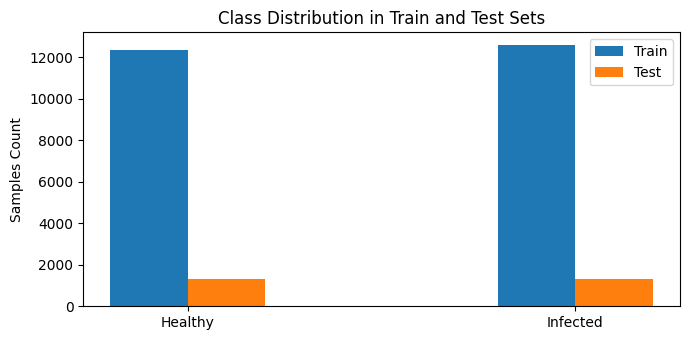

In [ ]:
def plot_class_distribution(train_labels, test_labels):
    # Count the occurrence of each class in the datasets
    unique, train_counts = np.unique(train_labels, return_counts=True)
    _, test_counts = np.unique(test_labels, return_counts=True)

    # Plotting
    classes = ['Healthy', 'Infected']
    fig, ax = plt.subplots(figsize=(7, 3.5))
    index = np.arange(len(classes))
    bar_width = 0.2
    train_bars = ax.bar(index - bar_width/2, train_counts, bar_width, label='Train')
    test_bars = ax.bar(index + bar_width/2, test_counts, bar_width, label='Test')

    ax.set_ylabel('Samples Count')
    ax.set_title('Class Distribution in Train and Test Sets')
    ax.set_xticks(index)
    ax.set_xticklabels(classes)
    ax.legend()
    plt.tight_layout()
    plt.show()


train_labels = read_labels_high_res(train_data_path_high_res)
test_labels = read_labels_high_res(test_data_path_high_res)
plot_class_distribution(train_labels, test_labels)


####<b> Observations and insights: </b>
Just a visual confirmation for people who may prefer images than the numbers. As we previously checked data is almost perfectly balanced.


### Let's visualize the images from the train data

In [ ]:
def display_images_6_x_6(healthy_images, infected_images):
  fig, axs = plt.subplots(6, 6, figsize=(12, 12))
  axs = axs.ravel()  # Flatten the array of axes for easy iteration
  all_images = healthy_images + infected_images
  for idx, img in enumerate(all_images):
    axs[idx].imshow(img)
    category_label = 'Healthy' if idx < len(healthy_images) else 'Infected'
    axs[idx].set_title(category_label)
    axs[idx].axis('off')
  plt.tight_layout()
  plt.show()

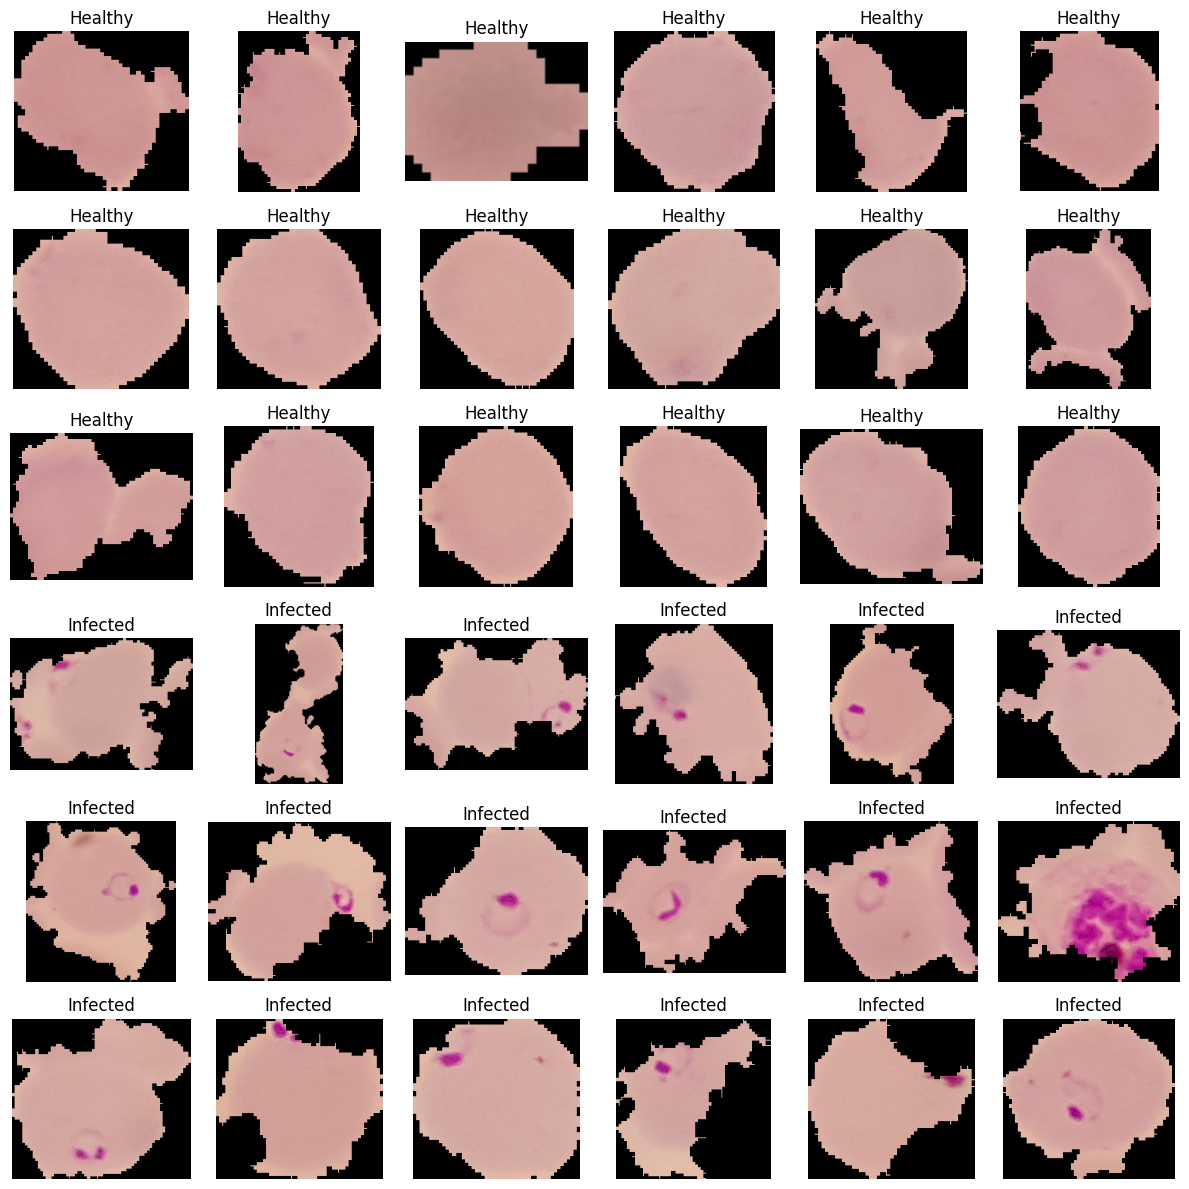

In [ ]:
def load_original_images(how_many, what_category):
  base_path = "/content/drive/MyDrive/projects/school/Capstone Project/data/cell_images/train/"
  folder_path = os.path.join(base_path, what_category)
  image_paths = []
  image_names = os.listdir(folder_path)[:how_many]
  image_paths.extend([os.path.join(folder_path, name) for name in image_names])
  images = []
  for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    images.append(img)
  return images

org_18_healthy_images = load_original_images(18, healthy)
org_18_infected_images = load_original_images(18, infected)
display_images_6_x_6(org_18_healthy_images, org_18_infected_images)

####<b> Observations and insights: </b>
It looks too simple. Basically detecting if there is little violet in the image and not all is pink would be enough to distingiquish infected cells. That's something I'd double check with specialist if I had access to any.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

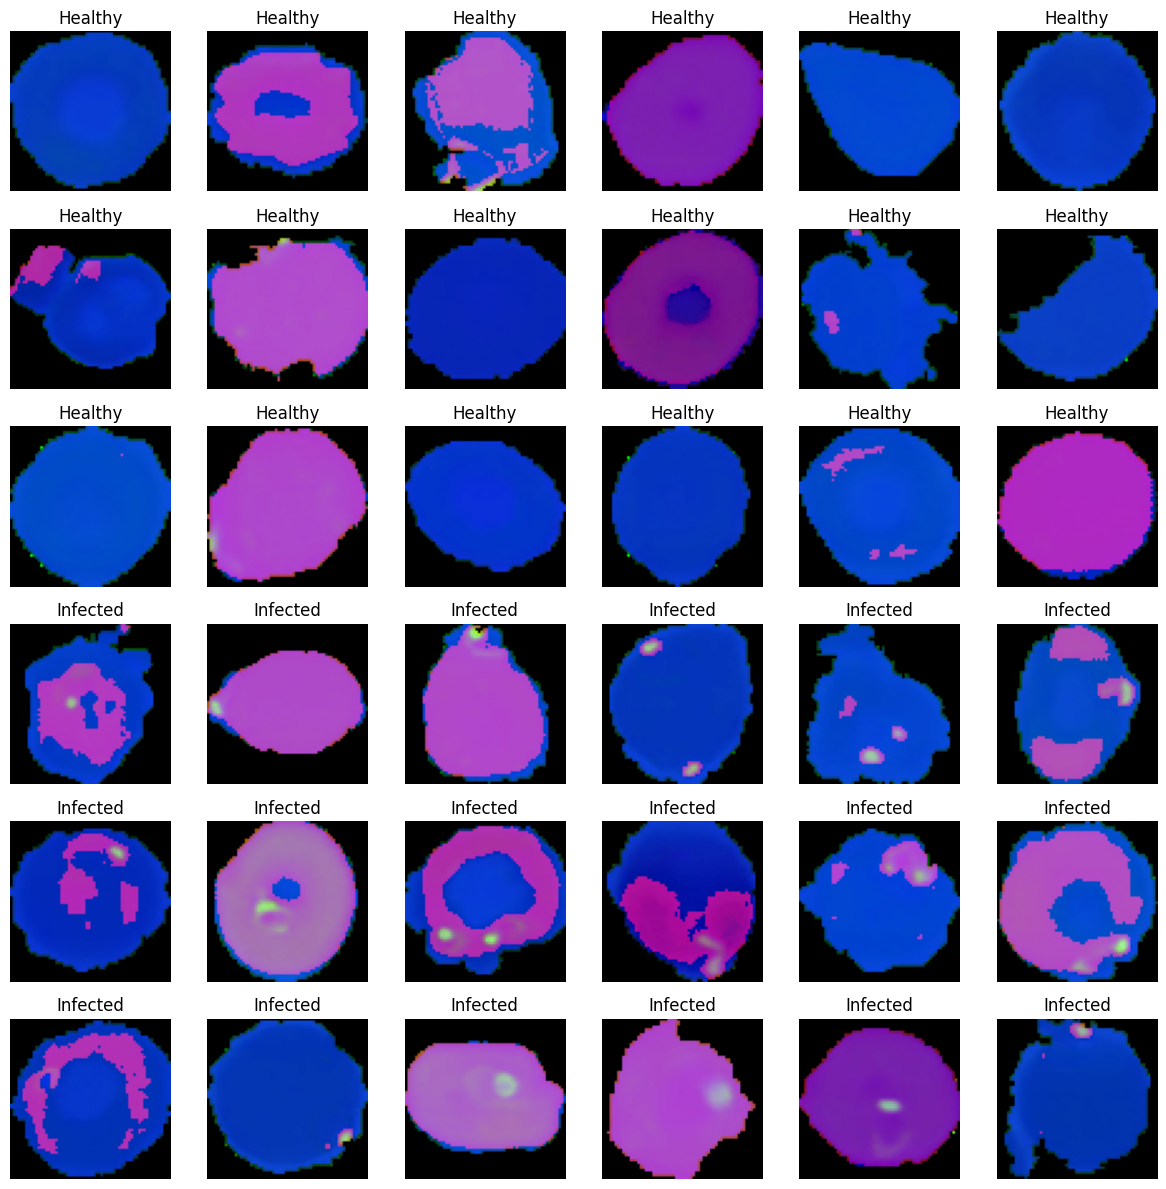

In [ ]:
def load_preprocessed_images(how_many, what_category):
  labels = read_labels_high_res(test_data_path_high_res)
  label_value = what_category != healthy
  indices = np.where(labels == label_value)[0]
  indices = indices[:how_many]
  images = []
  with h5py.File(test_data_path_high_res, 'r') as data_file:
    for idx in indices:
      img = np.array(data_file['images'][idx])
      images.append(img)
  return images

p_h_images = load_preprocessed_images(18, healthy)
p_i_images = load_preprocessed_images(18, infected)
display_images_6_x_6(p_h_images, p_i_images)

####<b>Observations and insights:</b>
**Problem:** Data and labels are inconsistent.
Labels are binary, infected/not infected, but images are precise with relatively high resolution (almost all of them are above 64x64 pixels) what is typical for good quality aparature and thin smear microscope analysis. But this method (thin smear) is used to learn about details of infection. For binary classification if malaria is present usually much different data is used - thick blood smears with much lower zoom level (10-40). In such case single cell is very small. Especially if it's to be widely used and applied to labs where equipment isn't top tier. In those cases single cell is just few by few pixels. Additionally cells are not well separated from each other. But thick smears allows to see much more cells and such tests have much more sensitive. Additionally thick smears are easier to prepare so this method is more applicable for widespread use. Additinally looking at the images shows that aspect ratio shouldn't be an issue, so we need to rescale the data to keep most information (aspect fit instead of aspect fill).

**Correction of assumptions** If this project has to resemble any real research problem we must try to detect presence of infection on as small images as possible - 8x8 is max we can assume. Additionally it must be really fast. In real world there may be well over thousand cells on single microscope image, so we would use analysis of single a lot for every single sample. It must be efficient.

**Note** At this stage we are hand-waving problem that in thick smear cells overlap, there are many layers of them. Probably best way would be to train model on whole sample images, not on single cells, but we have to work with what we have.


###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
# There are 1300 images for each category in Test data
# That should be enough, so we can save some time and do that on test data instead of
# computating much bigger training data set (around 13k images per category)
labels = read_labels_high_res(test_data_path_high_res)

def create_mean_image_from_test_set(label_value):
  indices = np.where(labels == label_value)[0]
  with h5py.File(test_data_path_high_res, 'r') as data_file:
    images = data_file['images']
    return np.mean(np.array([images[i] for i in indices]), axis=0)

def display_image(img, title):
  img_rgb = mcolors.hsv_to_rgb(img)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(img)
  axs[0].set_title(title + '  (HSV)')
  axs[0].axis('off')
  axs[1].imshow(img_rgb)
  axs[1].set_title(title + '  (RGB)')
  axs[1].axis('off')
  plt.show()

<b> Mean image for parasitized

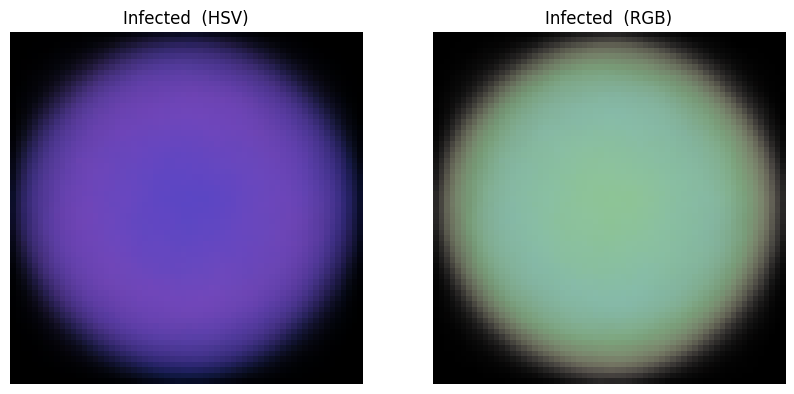

In [ ]:
mean_of_infected = create_mean_image_from_test_set(1)
display_image(mean_of_infected, "Infected")

<b> Mean image for uninfected

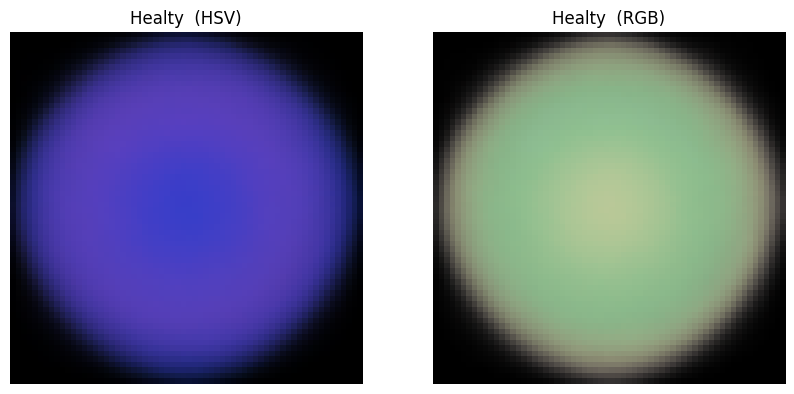

In [ ]:
mean_of_healthy = create_mean_image_from_test_set(0)
display_image(mean_of_healthy, "Healty")

<b> Since we have both means, let's mean difference

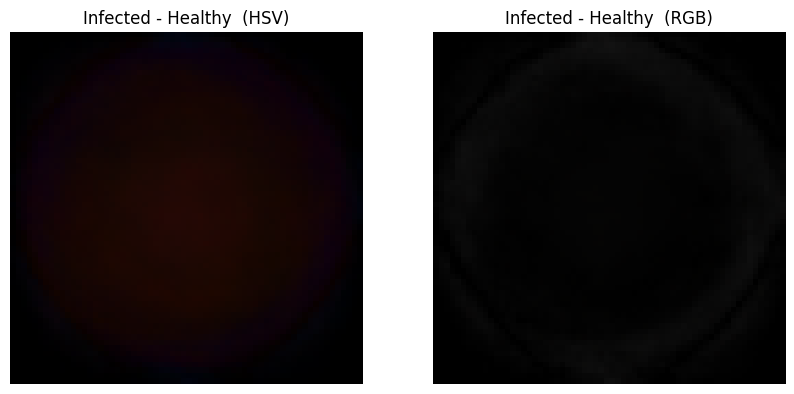

In [ ]:
mean_difference = abs(mean_of_healthy - mean_of_infected)
display_image(mean_difference, "Infected - Healthy")

In [ ]:
def display_separate_channels(img, colors='hsv'):
  hue, saturation, value = mean_difference[:,:,0], mean_difference[:,:,1], mean_difference[:,:,2]
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  def display_one_layer(channel, subplot, title):
    if subplot == 0:
      colorspace = colors
    else:
      colorspace = colors
    axs[subplot].imshow(channel, cmap=colorspace)
    axs[subplot].set_title(title)
    axs[subplot].axis('off')
  display_one_layer(img[:,:,0], 0, "Hue")
  display_one_layer(img[:,:,1], 1, "Saturation")
  display_one_layer(img[:,:,2], 2, "Value")
  plt.show()

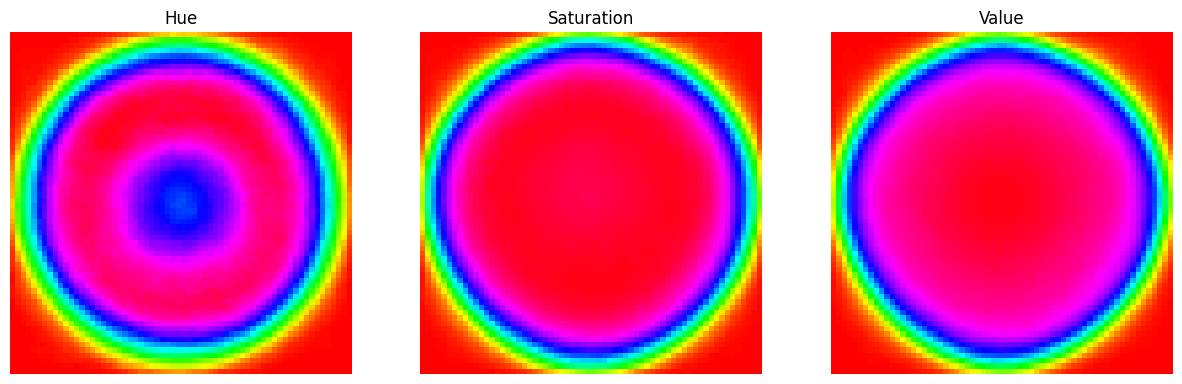

In [ ]:
display_separate_channels(mean_of_healthy)

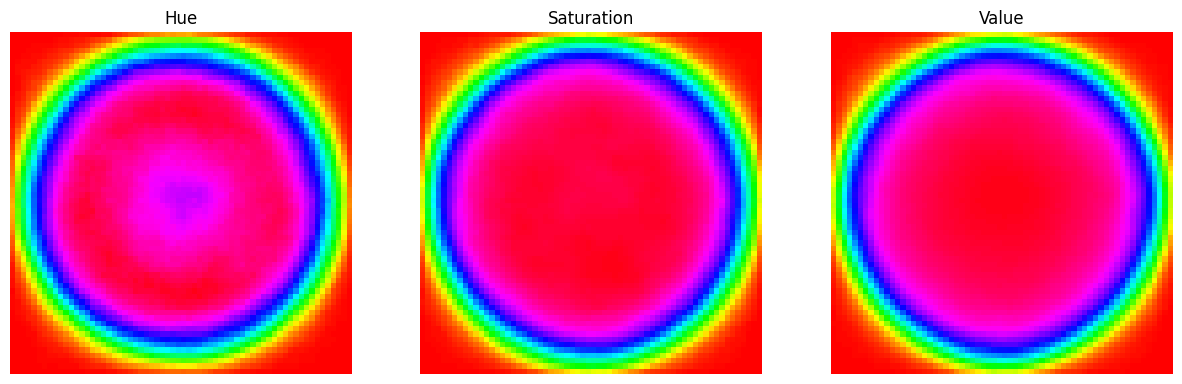

In [ ]:
display_separate_channels(mean_of_infected)

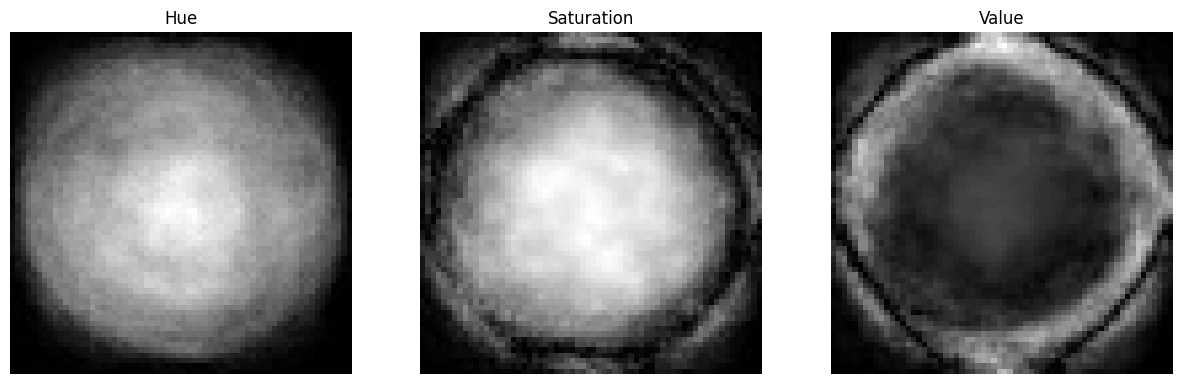

In [ ]:
display_separate_channels(mean_difference, colors='gray')

####<b> Observations and insights: </b>
Assumption: visual inspection should be done by someone wiht deep biological knowledge.
That said there are some clear visual differences.
Interesting insights:
- rgb space doesn't show much when subtracting means
- I have the feeling that hue (color information) is the biggest differentiator. More analysis on that should follow - if that was right we could reduce input size by removing some layers (value layer being probably least informative).
- It's very interesting that means shows biggest differences in area which roguhly translates to nucleus, while looking at original data seems to indicate that changes are in cytoplasm.  

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
# Already done

###<b> Converting the test data

In [ ]:
# Already done

####<b>Observations and insights: </b>
HSV format seems to be better fit for this task. Hue variations seems to carry most information. So maybe, quite maybe we could work with only this one layer.
If single image conatins over 1000 cells we need something fast, so any data that can be discarded needs to be discarded in preprocessing.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

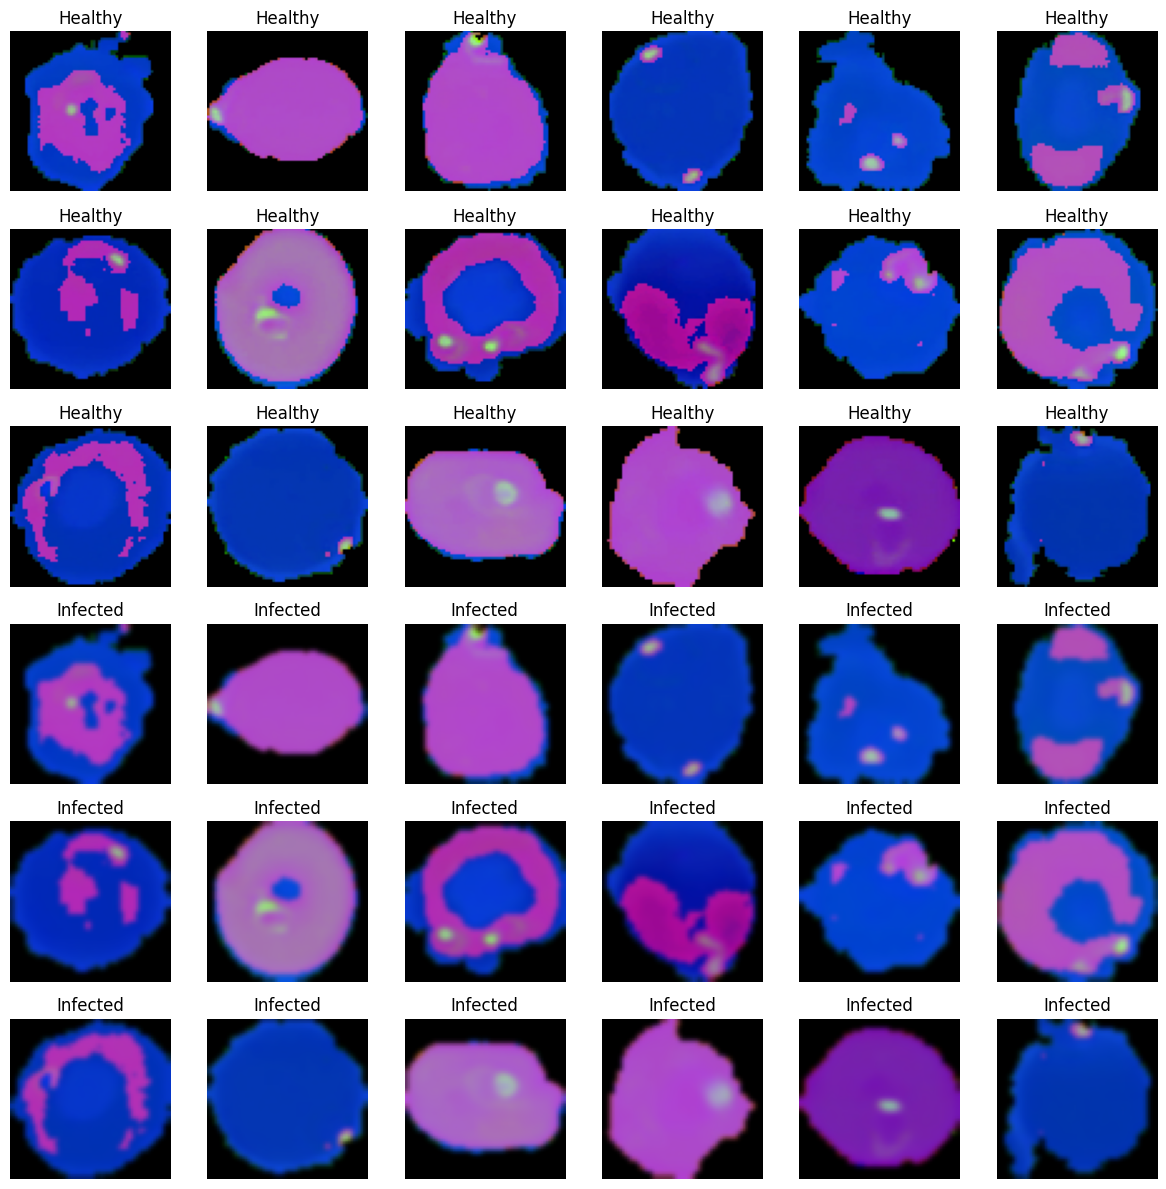

In [ ]:
def blur_images(images_to_be_blurred):
  blurred = []
  for img in images_to_be_blurred:
    blurry_img = cv2.GaussianBlur(img, (5, 5), sigmaX=1)
    blurred.append(blurry_img)
  return blurred


some_images = load_preprocessed_images(18, infected)
other_images = blur_images(some_images)
display_images_6_x_6(some_images, other_images)

###<b> Gaussian Blurring on test data

In [ ]:
# I'm not convinced I should follow this path

####**Observations and insights:**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?
- I prefer to explore other strategies. Although blurring training data might simulate the use of lower-cost microscopes for the final model—relevant in a price-sensitive market—I believe it adds little value at the research stage.
- I don't follow the path "because that's how it is done" - I've read that blurring is often applied to bilogical images, and it provides some noise that is good for reducing overfitting, but I don't think it's necessary now.
- We can create an augumented data... but I don't even applied simplest model yet and you want me to decide data optimization at this stage?

*Outdated: I tried 8x8 resolution, but accuracy was around 60% so it's not of any use.*

Last but not least, let's preapre some low resolution data to figure out how model works with it.

In [ ]:
# This is just to make data loading fast
def preprocess_image_8x8(file_path):
    """This function will convert image to uniform way:
    - 8x8 pixels without preserving aspect ratio to utilize all pixels
    - No other changes, transforming color, standardizing values will be part of model"""
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (8, 8), interpolation=cv2.INTER_AREA)
    return img

In [ ]:
def prepare_data_8x8(input_folder, output_file):
  """
  Preprocess images, shuffle them, and save along with labels to a .npz file.
  Parameters:
  - data_dir: Path to the data directory, which contains subdirectories for each class.
  - output_file_path: Path where the file will be stored
  """
  image_data = []
  labels = []
  print("preparing: ", input_folder)
  # Loop through each subdirectory in the input folder
  for subdir in sorted(os.listdir(input_folder)):
      subdir_path = os.path.join(input_folder, subdir)
      if os.path.isdir(subdir_path):
          # Determine the label based on the subdirectory name
          label = int(subdir == infected)
          for fname in os.listdir(subdir_path):
              file_path = os.path.join(subdir_path, fname)
              if os.path.isfile(file_path):
                  img = preprocess_image_8x8(file_path)
                  image_data.append(img)
                  labels.append(label)

  # Convert lists to numpy arrays and shouffle it
  image_data = np.array(image_data, dtype=np.float32)
  labels = np.array(labels, dtype=np.int8)
  image_data, labels = shuffle(image_data, labels, random_state=44)

  # Save the processed dataset to a .npz file for easy loading
  np.savez(output_file, images=image_data, labels=labels)
  print(f'Dataset saved to {output_file}.npz with {len(image_data)} images and binary labels.')

In [ ]:
prepare_data_8x8(test_data_folder, test_data_file_8x8)

preparing:  /content/drive/MyDrive/projects/school/Capstone Project/data/cell_images/test/
Dataset saved to /content/drive/MyDrive/projects/school/Capstone Project/test_data_8x8.npz.npz with 2600 images and binary labels.


In [ ]:
prepare_data_8x8(train_data_folder, train_data_file_8x8)

preparing:  /content/drive/MyDrive/projects/school/Capstone Project/data/cell_images/train/
Dataset saved to /content/drive/MyDrive/projects/school/Capstone Project/train_data_8x8.npz.npz with 24958 images and binary labels.


# **Model Building**

In [4]:
train_images_64x64 = read_images_high_res(train_data_path_high_res)
train_labels_64x64 = read_labels_high_res(train_data_path_high_res)
test_images_64x64 = read_images_high_res(test_data_path_high_res)
test_labels_64x64 = read_labels_high_res(test_data_path_high_res)

In [ ]:
# No more used - I played with it but accuracy of around 60% was dramatically too low
test_images_8x8, test_labels_8x8 = read_data_8x8(test_data_file_8x8)
train_images_8x8, train_labels_8x8 = read_data_8x8(train_data_file_8x8)

## **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [ ]:
# Loaded all them in one place at the beginning

####<B>One Hot Encoding the train and test labels

In [ ]:
# Already done - DRY principle

###<b> Building the model

I'll make very simple CNN model, just to get grasp how it works, what are the results, get the feel of how this data works with NN.

In [ ]:
model_1 = Sequential([
        Conv2D(6, kernel_size=(3, 3), padding='valid', input_shape=(64, 64, 3)),
        PReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(4, kernel_size=(3, 3), padding='valid'),
        PReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(16),
        PReLU(),
        Dense(1, activation='sigmoid')
    ])

###<b> Compiling the model

In [ ]:
# Function defined at the top to not repeat the same code again and agian (DRY principle)

<b> Using Callbacks

In [ ]:
# Function defined at the top to not repeat the same code again and agian (DRY principle)

<b> Fit and train our Model

In [ ]:
compile_and_fit_model(
    model=model_1,
    model_name="model_1",
    images=train_images_64x64,
    labels=train_labels_64x64,
    epochs=20,
    batch_size=512)

Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 0.6374 - accuracy: 0.6507 - auc_8: 0.6989
Epoch 1: val_loss improved from inf to 0.60156, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_1.keras
37/37 [==============================] - 60s 2s/step - loss: 0.6374 - accuracy: 0.6507 - auc_8: 0.6989 - val_loss: 0.6016 - val_accuracy: 0.6994 - val_auc_8: 0.7454
Epoch 2/20
37/37 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.6932 - auc_8: 0.7499
Epoch 2: val_loss improved from 0.60156 to 0.58442, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_1.keras
37/37 [==============================] - 51s 1s/step - loss: 0.5965 - accuracy: 0.6932 - auc_8: 0.7499 - val_loss: 0.5844 - val_accuracy: 0.6994 - val_auc_8: 0.7666
Epoch 3/20
37/37 [==============================] - ETA: 0s - loss: 0.5773 - accuracy: 0.7043 - auc_8: 0.7762
Epoch 3: val_loss improved from 0.58442 to 0.56946, saving model to 

###<b> Evaluating the model on test data

In [ ]:
model_1_predictions = predictions("model_1", test_images_64x64, test_labels_64x64)

Test accuracy: 0.9438461661338806
82/82 [==============================] - 2s 23ms/step


<b> Plotting the confusion matrix

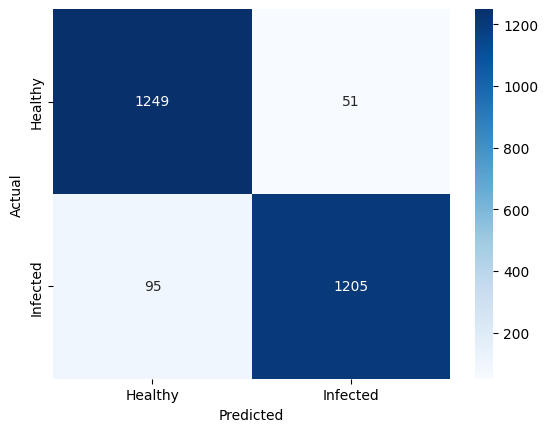

In [ ]:
show_confusion(test_labels_64x64, model_1_predictions)

<b>Plotting the train and validation curves

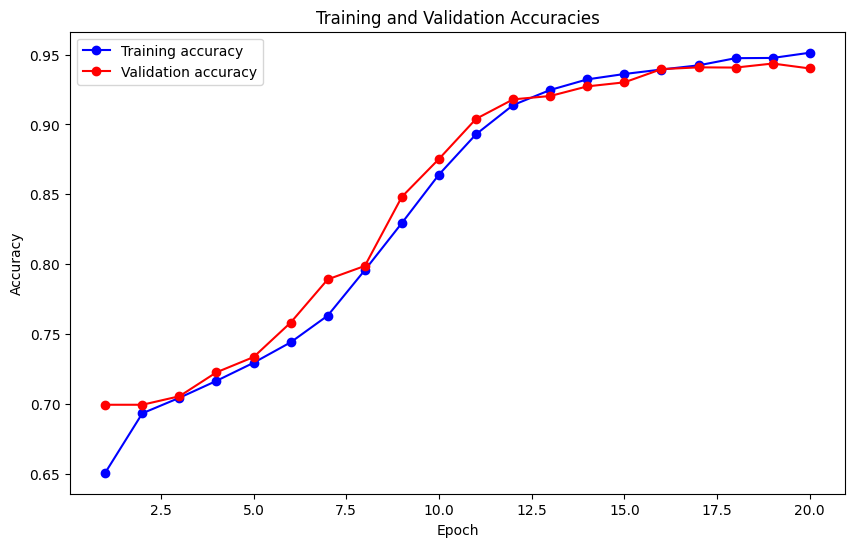

In [ ]:
plot_accuracy("model_1")

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

##<b> Model 2
####<b> Trying to improve the performance of our model by adding new layers


It's not the way I'd go, first very simple CNN has really good initial accuracy, I should tweak it, but as required for passing the exam purposes I'll do something more complex.

###<b> Building the Model

In [ ]:
model_2 = Sequential([
        Conv2D(18, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(alpha=0.25),
        Conv2D(16, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.20),
        Conv2D(12, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.15),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.10),
        Flatten(),
        Dense(32, activation='sigmoid'),
        Dense(18, activation='sigmoid'),
        Dense(1, activation='sigmoid')
    ])

###<b> Compiling the model

In [ ]:
# Function defined at the top to not repeat the same code again and agian (DRY principle)

<b> Using Callbacks

In [ ]:
# Function defined at the top to not repeat the same code again and agian (DRY principle)

<b>Fit and Train the model

In [ ]:
compile_and_fit_model(model_2, "model_2",
                      images=train_images_64x64,
                      labels=train_labels_64x64,
                      validation_split=0.25,
                      epochs=25,
                      batch_size=512)

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.6058 - auc_9: 0.6595
Epoch 1: val_loss improved from inf to 0.62423, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_2.keras
37/37 [==============================] - 235s 6s/step - loss: 0.6589 - accuracy: 0.6058 - auc_9: 0.6595 - val_loss: 0.6242 - val_accuracy: 0.6726 - val_auc_9: 0.7289
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.6954 - auc_9: 0.7510
Epoch 2: val_loss improved from 0.62423 to 0.58834, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_2.keras
37/37 [==============================] - 194s 5s/step - loss: 0.6009 - accuracy: 0.6954 - auc_9: 0.7510 - val_loss: 0.5883 - val_accuracy: 0.6938 - val_auc_9: 0.7672
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7164 - auc_9: 0.7882
Epoch 3: val_loss improved from 0.58834 to 0.57091, saving model t

###<b> Evaluating the model

In [ ]:
model_2_predictions = predictions("model_2", test_images_64x64, test_labels_64x64)

Test accuracy: 0.9680769443511963
82/82 [==============================] - 8s 92ms/step


<b> Plotting the confusion matrix

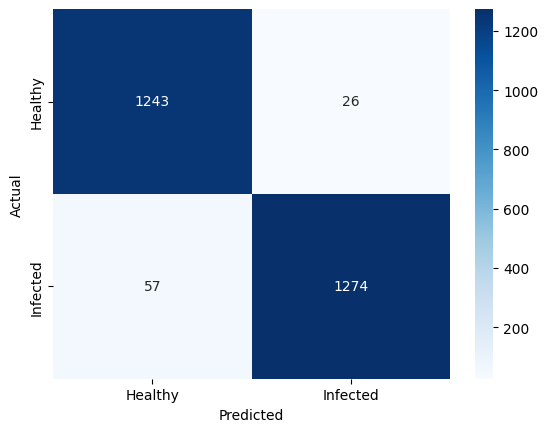

In [ ]:
show_confusion(model_2_predictions, test_labels_64x64)

<b> Plotting the train and the validation curves

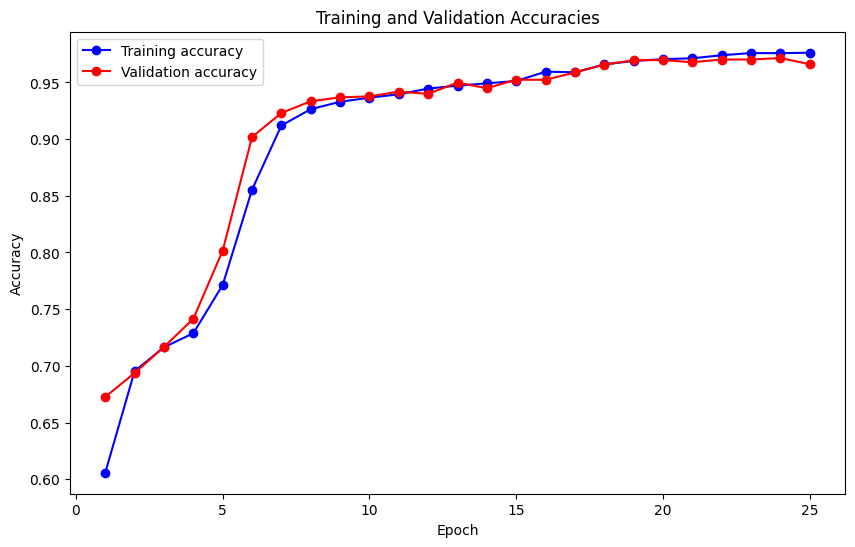

In [ ]:
plot_accuracy("model_2")

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

NOTE: not sure how to read this instruction:
- I used LeakyRelu previously, so how am I to change to something that was there? It's very innacurate
- Can BatchNormalization help? That is compound question. How are we to decide if normalization or change or activation function helped... this questions should be improved or removed.

Trying to follow unclear and inconstent instructions I'll just use previous model and add some normalization.

##<b> Model 3 with Batch Normalization

###<b> Building the Model

In [ ]:
model_3 = Sequential([
        Conv2D(18, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(alpha=0.25),
        BatchNormalization(),
        Conv2D(16, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.20),
        BatchNormalization(),
        Conv2D(12, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.15),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.10),
        Flatten(),
        Dense(32, activation='sigmoid'),
        BatchNormalization(),
        Dense(18, activation='sigmoid'),
        Dense(1, activation='sigmoid')
    ])

###<b>Compiling the model

In [ ]:
# Function defined at the top to not repeat the same code again and agian (DRY principle)

<b> Using callbacks

In [ ]:
# Function defined at the top to not repeat the same code again and agian (DRY principle)

<b>Fit and train the model

In [ ]:
compile_and_fit_model(model_3, "model_3",
                      images=train_images_64x64,
                      labels=train_labels_64x64,
                      epochs=13)

Epoch 1/13
37/37 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.7450 - auc_10: 0.8167
Epoch 1: val_loss improved from inf to 0.61325, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_3.keras
37/37 [==============================] - 253s 7s/step - loss: 0.5218 - accuracy: 0.7450 - auc_10: 0.8167 - val_loss: 0.6133 - val_accuracy: 0.7470 - val_auc_10: 0.7958
Epoch 2/13
37/37 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8915 - auc_10: 0.9420
Epoch 2: val_loss did not improve from 0.61325
37/37 [==============================] - 238s 6s/step - loss: 0.3189 - accuracy: 0.8915 - auc_10: 0.9420 - val_loss: 0.6232 - val_accuracy: 0.7317 - val_auc_10: 0.8637
Epoch 3/13
37/37 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9479 - auc_10: 0.9820
Epoch 3: val_loss did not improve from 0.61325
37/37 [==============================] - 260s 7s/step - loss: 0.2002 - accuracy: 0.9479 - auc_10: 0.982

<b>Plotting the train and validation accuracy

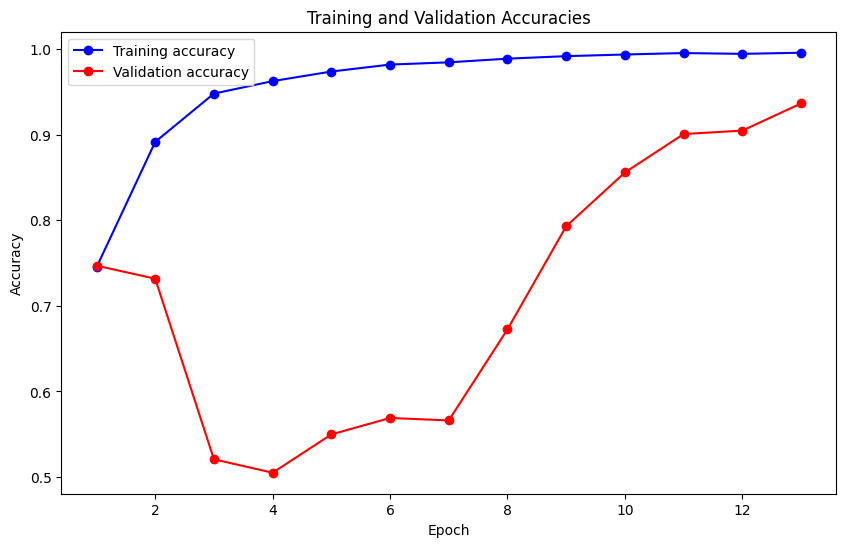

In [ ]:
plot_accuracy("model_3")


###<b>Evaluating the model

In [ ]:
model_3_predictions = predictions("model_3", test_images_64x64, test_labels_64x64)

Test accuracy: 0.9411538243293762
82/82 [==============================] - 8s 91ms/step


####<b>Observations and insights:</b>
It was great lesson, as I runned this twice, because once file did not save and I couldn't load model to make predictions and shape of validation accuracy was very different.
Anyway - because such high difference between training accuracy and validation accuracy this model shouldn't be trusted, I wouldn't use anything like this without much wider tests. So BatchNormalization can make model perform worse.

<b> Generate the classification report and confusion matrix

In [ ]:
print("Classification Report:")
print(classification_report(test_labels_64x64, model_3_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1300
           1       1.00      0.89      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.95      0.94      0.94      2600
weighted avg       0.95      0.94      0.94      2600



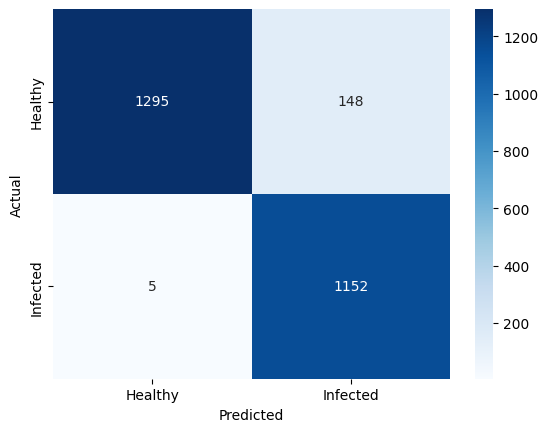

In [ ]:
show_confusion(model_3_predictions, test_labels_64x64)

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





I don't believe data augumentation will do much good. Data set is relatively large, especially if we strive for small model that can work with number of cells in range of dozen hunders per single test sample.
Additionally data is quite divers. Cells in training data are in various ratios, rotations, and from few microspocopes with various lighning conditions... however this last point where we could still try to do better: Color Jittering could be applied.

Since model_2 had accuracy of 0.98 without even tweaking hyperparameters, and it's definitely not the production model there is very little reason to try next model instead of optimizing previous ones.
So I'll do something little different - I'll generate copy of dataset with cell size of 8x8 pixels what more closely resembles what we would need for production model that can be wiedly adapted. I won't go for detailed analysis, just run previous model to have insight how problematic and how hard it may be to optimize model for production. What works in well establisched lab with carefully prepared samples by very well skilled technician using state of the art aparature may not be (even with lot of work) applicable to production where smaples will be much lower quality and model has to work has to be efficient.

##<b>Model 4 with Data Augmentation

###<b> Use image data generator

Image Data Generator is depreciated and not advised, so I'll do it other way - especially that above I presented how to preprocess data in separate process.

In [7]:
# I've chosen different startegy, to have preprocessing directly in the model,
# while training data is rescaled in a file for easy loading, but this is how it would be done.
# Additionally ImageDataGenerator is depreciated: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

validation_generator =  test_datagen.flow_from_directory(
    test_data_folder,
    batch_size=20,
    class_mode  = 'binary',
    target_size = (8, 8))

train_datagen = ImageDataGenerator(
    brightness_range=(0.7, 1.0),
    channel_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_data_folder,
    batch_size=20,
    class_mode='binary',
    target_size=(8, 8))

Found 2600 images belonging to 2 classes.
Found 24958 images belonging to 2 classes.


In [7]:
# Code below could be clearer, but then I'd need to rerun whole notebook
# And given restrictions applied by googl on colab it may take too long

@register_keras_serializable(package='Custom', name='RgbToHsv')
class RgbToHsv(tf.keras.layers.Layer):
    def __init__(self):
        super(RgbToHsv, self).__init__()

    def call(self, inputs):
        return tf.image.rgb_to_hsv(inputs)

@register_keras_serializable(package='Custom', name='HsvToRgb')
class HsvToRgb(tf.keras.layers.Layer):
    def __init__(self):
        super(HsvToRgb, self).__init__()

    def call(self, inputs):
        return tf.image.hsv_to_rgb(inputs)

@register_keras_serializable(package='Custom', name='ColorShift')
class ColorShift(tf.keras.layers.Layer):
    def __init__(self, factor=0.1):
        super(ColorShift, self).__init__()
        self.factor = factor

    def call(self, inputs, training=None):
        if not training:
            return inputs
        # Randomly adjust the hue of the input images
        delta = tf.random.uniform((), -self.factor, self.factor)
        return tf.image.adjust_hue(inputs, delta)

# I'm aware there is keras.RandomBrigness(...)
# but it was causing some troubles, so easier to simply redefine...
# later I should dug in and understand why it behaves so unexpectedly
@register_keras_serializable(package='Custom', name='BrightnessShift')
class BrightnessShift(tf.keras.layers.Layer):
    def __init__(self, factor=0.2):
        super(BrightnessShift, self).__init__()
        self.factor = factor

    def call(self, inputs):
        adjusted = inputs + tf.random.uniform(shape=[], minval=-self.factor, maxval=self.factor)
        return tf.clip_by_value(adjusted, clip_value_min=0.0, clip_value_max=1.0)

# Color shifting and brightness randomization require rgb color space, therefore we
# needed to split preprocessing into two stages - one before randomization, and second one after
early_preprocessing = tf.keras.Sequential([
    HsvToRgb(), # normally what wouldn't be required but that's my preprocessed data
    #tf.keras.layers.Rescaling(1./255)
])

# Data is really well diverse in shapes, sizes, rotations, etc.
# One thing that still could be more diferese is to simulate more different
# Ligting conditions
trainig_data_augmentation = tf.keras.Sequential([
    BrightnessShift(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
    ColorShift(factor=0.2),
])

# It's late, as converting to HSV color space must be done after working with colors
# Color functions assume they work on RGB data
late_preprocessing = tf.keras.Sequential([
    RgbToHsv()
])

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.

I might run it with previous data on different models, but I don't want this notebook to explode into long book. And it's always nice to stick to chosen goal instead of doing fancy stuff to show off.



####<B>Visualizing Augmented images

In [ ]:
augmented_images = test_images_64x64[:32]
augmented_images = early_preprocessing(tf.stack(augmented_images, axis=0), training=True)
augmented_images = trainig_data_augmentation(augmented_images, training=True)
augmented_images_labels = test_labels_64x64[:32]

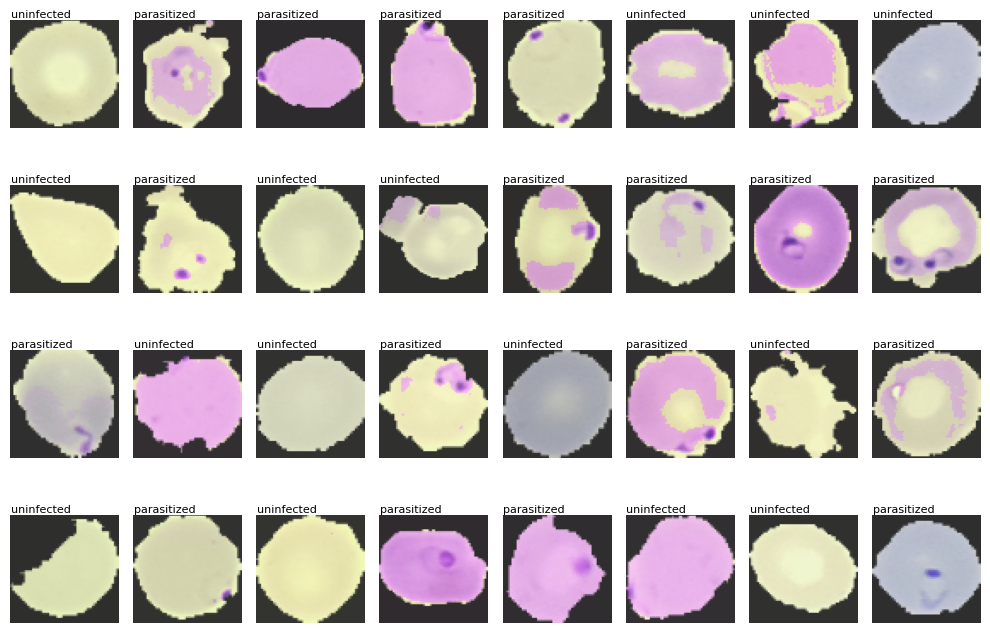

In [ ]:
ig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
  ax.imshow(augmented_images[i])
  ax.axis('off')
  if augmented_images_labels[i] == 0:
    label = healthy
  else:
    label = infected
  ax.text(0, -2, label, fontsize=8, ha='left')
plt.tight_layout()
plt.show()

####<b>Observations and insights:</b>
- Definitely this way we can simulate much wider range of lighting conditions and prepare our model to work with much more diverse input (from different types of microscopes), but probably used factor is too big.

###<b>Building the Model

For comparision reasons I'm using best model so far. Difference is that data preprocessing is included in model, and we use data augmentation for training and finally image resolution is much lower.

In [ ]:
model_4 = Sequential([
        early_preprocessing,
        trainig_data_augmentation,
        late_preprocessing,
        Conv2D(18, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(alpha=0.25),
        Conv2D(16, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.20),
        Conv2D(12, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.15),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, kernel_size=(3, 3), padding='same'),
        LeakyReLU(alpha=0.10),
        Flatten(),
        Dense(64, activation='sigmoid'),
        Dense(16, activation='sigmoid'),
        Dense(1, activation='sigmoid')
    ])

<b>Using Callbacks

In [ ]:
# inside function compile_and_fit_model (DRY principle)

<b> Fit and Train the model

In [ ]:
compile_and_fit_model(model_4, "model_4", train_images_64x64, train_labels_64x64, epochs=50, learning_rate=0.0002)

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5837 - auc: 0.6150
Epoch 1: val_loss improved from inf to 0.65130, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_4.keras
37/37 [==============================] - 22s 273ms/step - loss: 0.6763 - accuracy: 0.5837 - auc: 0.6150 - val_loss: 0.6513 - val_accuracy: 0.6256 - val_auc: 0.6836
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6107 - auc: 0.6412
Epoch 2: val_loss improved from 0.65130 to 0.64230, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_4.keras
37/37 [==============================] - 4s 109ms/step - loss: 0.6622 - accuracy: 0.6107 - auc: 0.6412 - val_loss: 0.6423 - val_accuracy: 0.6353 - val_auc: 0.7007
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.6243 - auc: 0.6657
Epoch 3: val_loss improved from 0.64230 to 0.63821, saving model to /content/

###<B>Evaluating the model

<b>Plot the train and validation accuracy

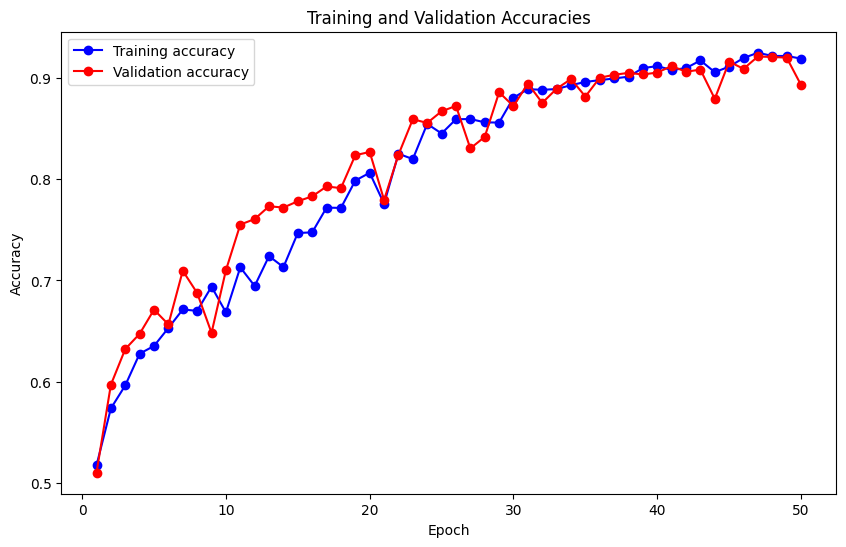

In [5]:
plot_accuracy("model_4")

<B>Plotting the classification report and confusion matrix

In [8]:
model_4_predictions = predictions("model_4", test_images_64x64, test_labels_64x64)
print("Classification Report:")
print(classification_report(test_labels_64x64, model_4_predictions))

Test accuracy: 0.9157692193984985
82/82 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1300
           1       0.91      0.91      0.91      1300

    accuracy                           0.91      2600
   macro avg       0.91      0.91      0.91      2600
weighted avg       0.91      0.91      0.91      2600



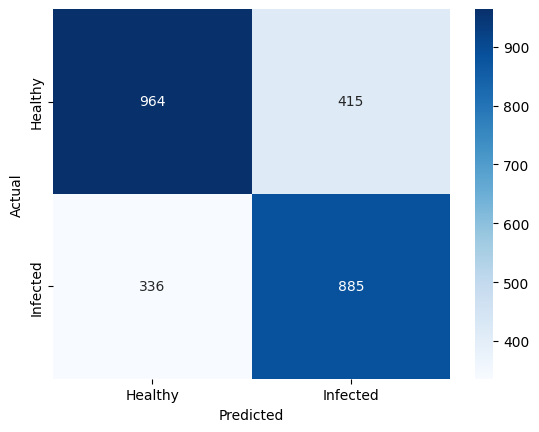

In [ ]:
show_confusion(model_4_predictions, test_labels_8x8)

### Conclusions:
- Images are very color sensitive. That was expected, but it would require multiple runs to figure out which parameters we can tweak, and which are not to be touched, or in what range to apply changes. And still it may not help at all.

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

## **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model_vgg.summary() # displaying so I know what layer are there to pick from

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

I'm cutting last few layers from feature extraction part for two reasons:

1. It's too slow to train it with all the layers.
2. They are most probably trained to detect features sepecific to training dataset they were trained on, and blood cells were not one of them.

In [ ]:
transfer_layer = model_vgg.get_layer('block3_pool')
model_vgg = Model(inputs=model_vgg.input, outputs=transfer_layer.output)
for layer in model_vgg.layers:
    layer.trainable = False
model_5 = Sequential()
model_5.add(model_vgg)
model_5.add(Flatten())
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

###<b>Compiling the model

In [ ]:
# inside function compile_and_fit_model (DRY principle)

<b> using callbacks

In [ ]:
# inside function compile_and_fit_model (DRY principle)

<b>Fit and Train the model

In [ ]:
# It's extremely slow, so running just for 9 epochs to get the idea about how it goes
compile_and_fit_model(model_5, "model_5", train_images_64x64, train_labels_64x64, epochs=9)

Epoch 1/9
37/37 [==============================] - ETA: 0s - loss: 10.1576 - accuracy: 0.6500 - auc_3: 0.6644 
Epoch 1: val_loss improved from inf to 1.49400, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_5.keras
37/37 [==============================] - 826s 22s/step - loss: 10.1576 - accuracy: 0.6500 - auc_3: 0.6644 - val_loss: 1.4940 - val_accuracy: 0.8189 - val_auc_3: 0.8661
Epoch 2/9
37/37 [==============================] - ETA: 0s - loss: 0.9483 - accuracy: 0.8441 - auc_3: 0.8949 
Epoch 2: val_loss improved from 1.49400 to 0.53175, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_5.keras
37/37 [==============================] - 814s 22s/step - loss: 0.9483 - accuracy: 0.8441 - auc_3: 0.8949 - val_loss: 0.5318 - val_accuracy: 0.8651 - val_auc_3: 0.9289
Epoch 3/9
37/37 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8854 - auc_3: 0.9456 
Epoch 3: val_loss improved from 0.53175 to 0.39320, saving mod

<b>Plot the train and validation accuracy

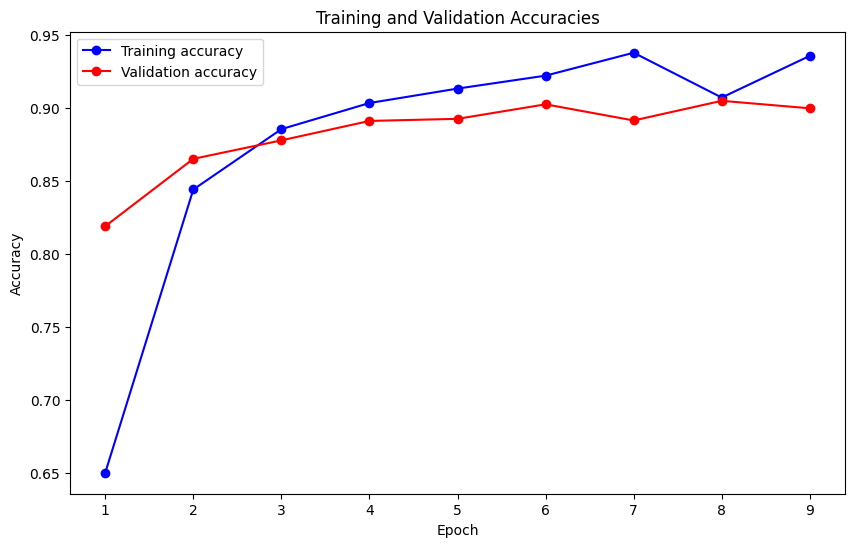

In [ ]:
plot_accuracy("model_5")

###**Observations and insights:**

*   What can be observed from the validation and train curves?

Model overfits a little.

###<b> Evaluating the model

In [ ]:
model_5_predictions = predictions("model_5", test_images_64x64, test_labels_64x64)


Test accuracy: 0.885769248008728
82/82 [==============================] - 86s 1s/step


<b>Plotting the classification report and confusion matrix

In [ ]:
print("Classification Report:")
print(classification_report(test_labels_64x64, model_5_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1300
           1       0.89      0.88      0.88      1300

    accuracy                           0.89      2600
   macro avg       0.89      0.89      0.89      2600
weighted avg       0.89      0.89      0.89      2600



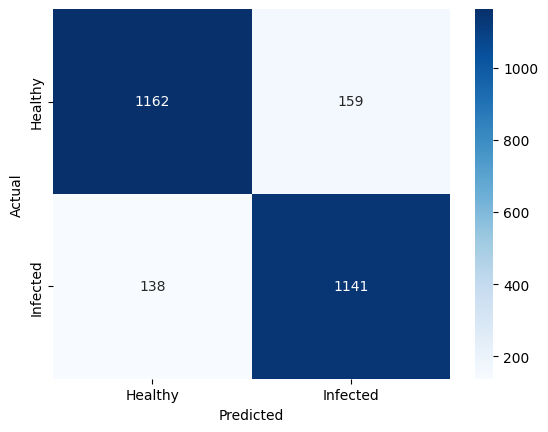

In [ ]:
show_confusion(model_5_predictions, test_labels_64x64)

###<b>Think about it:</b>





*  What observations and insights can be drawn from the confusion matrix and classification report?

Model 5 is surprisingly accurate considering it has weigths for features detection were trained on very, very different data, I was really expecting much worse performance. This shows how really good VGG16 architecture is, however it's still no go for our requirements, but that will be discussed in final section.

## **Model 6 with lower resolution images**


Let's see how our best model works if we scale data down, it may be important as market is very price sensitive and microscopes used there may not be top class.

In [11]:
model_6 = Sequential([
    tf.keras.layers.Resizing(32, 32, 'bilinear'),
    Conv2D(18, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)),
    LeakyReLU(alpha=0.25),
    Conv2D(16, kernel_size=(3, 3), padding='same'),
    LeakyReLU(alpha=0.20),
    Conv2D(12, kernel_size=(3, 3), padding='same'),
    LeakyReLU(alpha=0.15),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, kernel_size=(3, 3), padding='same'),
    LeakyReLU(alpha=0.10),
    Flatten(),
    Dense(32, activation='sigmoid'),
    Dense(18, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [12]:
compile_and_fit_model(model_6, "model_6",
                      images=train_images_64x64,
                      labels=train_labels_64x64,
                      validation_split=0.25,
                      epochs=25,
                      batch_size=512)

Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5440 - auc_1: 0.5595
Epoch 1: val_loss improved from inf to 0.66571, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_6.keras
37/37 [==============================] - 7s 97ms/step - loss: 0.6913 - accuracy: 0.5440 - auc_1: 0.5595 - val_loss: 0.6657 - val_accuracy: 0.5984 - val_auc_1: 0.6728
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.6971 - auc_1: 0.7444
Epoch 2: val_loss improved from 0.66571 to 0.52753, saving model to /content/drive/MyDrive/projects/school/Capstone Project/model_6.keras
37/37 [==============================] - 1s 41ms/step - loss: 0.6012 - accuracy: 0.6971 - auc_1: 0.7444 - val_loss: 0.5275 - val_accuracy: 0.7726 - val_auc_1: 0.7897
Epoch 3/25
35/37 [===========================>..] - ETA: 0s - loss: 0.4759 - accuracy: 0.8074 - auc_1: 0.8398
Epoch 3: val_loss improved from 0.52753 to 0.39865, saving model t

In [13]:
model_6_predictions = predictions("model_6", test_images_64x64, test_labels_64x64)

Test accuracy: 0.9815384745597839
82/82 [==============================] - 0s 3ms/step


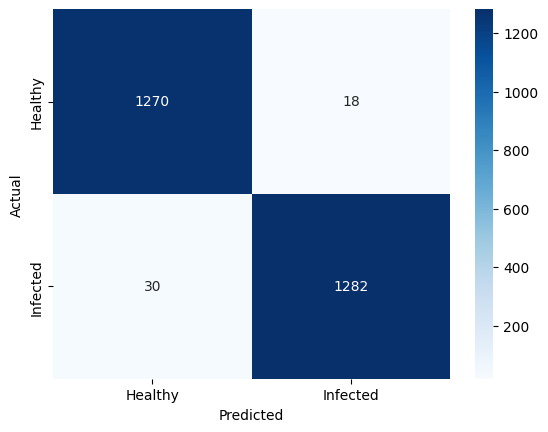

In [15]:
show_confusion(model_6_predictions, test_labels_64x64)

That is kinda surprising, but it's very fortunate that 32x32 is the way to go, that means we can use our tool for microscopes that have less magnification, which should be cheaper what is crucial for such price sensitive market.

In [28]:
mismatch_indices = np.where(model_6_predictions.flatten() != test_labels_64x64)[0]
misclassified_images = test_images_64x64[mismatch_indices]
misclassified_labels = test_labels_64x64[mismatch_indices]

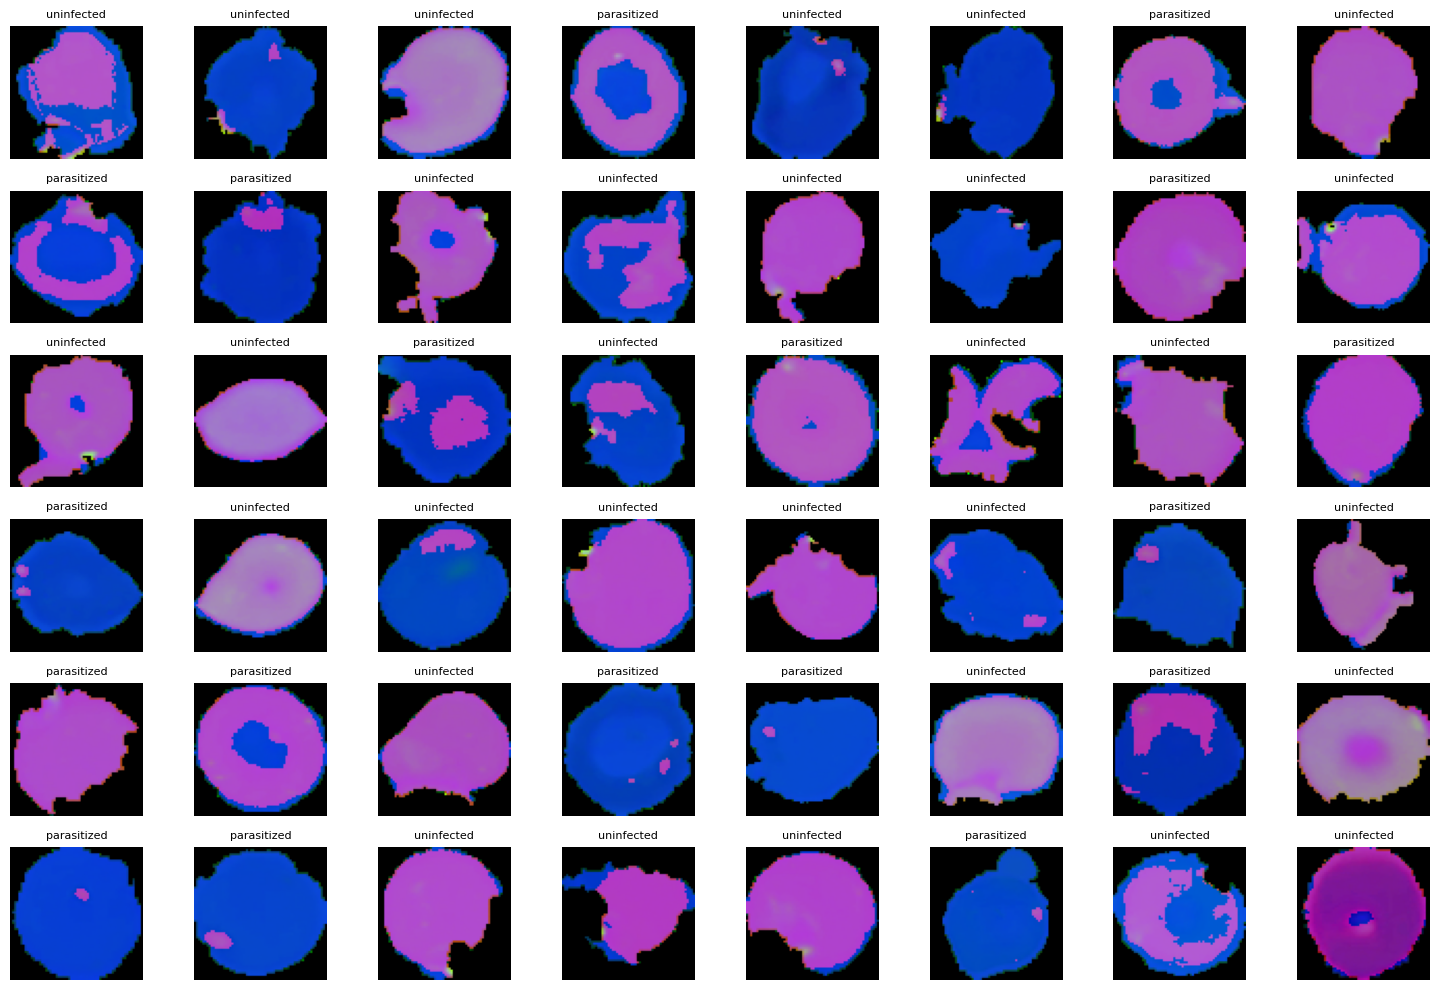

In [31]:
fig, axes = plt.subplots(6, 8, figsize=(15, 10))
axes = axes.flatten()
for i in range(48):
    axes[i].imshow(misclassified_images[i])
    axes[i].axis('off')
    label = healthy if misclassified_labels[i] < 0.5 else infected
    axes[i].set_title(label, fontsize=8)
plt.tight_layout()
plt.show()

Looking in HSV it looks like many of those are just mislabeled, but that would need to be confirmed by professional diagnostician. Guessing that about half of them are mislabeled, whe can halve the error and claim we can reach over 99% accuracy, also taking into account that probably training data has mislabeled data. For such high accuracy, we may need to return mismatched data for relabeling and then run whole model again and check how it works. Still > 99% is secure claim.

## <b> Project summary

*  Choose the model with the best accuracy scores from all the above models and save it as a final model.

All models are saved, and no model fits the goals, even if after relabeling mislabeled data we could improve accuracy to 99.9%. That would still be a no-go, because whole initial assumptions are wrong.

To detect malaria, we need to test well over a hundred cells (1% infected cells is a normal level of how malaria infects blood), so we need to detect a single infected cell in hundreds of images. Even 0.5% false positives will result in the classification of a really unacceptable amount of samples (sample being those hundreds of cells) as false positives.

####<b> Observations and Conclusions drawn from the final model:



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?

We could try deep architecture like VGG16, but this time with retraining all weights and feature detection on data specific to our problem.

We could also improve model_6 which had 98% accuracy, but there is hard way to get better values without carefully fixing mislabeled data.

*  You can try to build a model using these HSV images and compare them with your other models.

Yes, I'm using only HSV, as EDA has shown it's clearly the way to go.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

The problem is solvable; initial experiments show computer vision is able to distinguish cells infected with malaria with very high accuracy (98%) even with data that contain some labeling errors.

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

Simple models are doing great job. Features are simple, it's not complex geometry that must be recognized.

Yes - there is still some scope, just don't use batch normalization and don't use data pretrained on detecting dogs, planes, and other unrelated objects.


####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

None - we need to get back to business and, using gained insight, proceed with a different approach and different data.



## Business asumptions reevaluation:



We used the wrong data, that was clear from the start, but the results of this preliminary study are very promising and show that computer vision algorithms are able to detect infected cells with high accuracy and the project should be continued.

### <b>Not enough data:</b>
- The thin blood smear area is assumed to be 10x20 mm.
- White blood cells are approximately 1% of blood volume, so we are working with data equivalent to 100x200 micrometers.
- One cell is about 15x15 micrometers, so that gives us about 80 cells in a sample.
- Malaria may infect less than 1% of cells, so such a number is not enough, now counting for optimizing for no false positives (1% false positives would end up in most healthy samples classified as infected) would yield poor results.
- We can't scale samples, as that would require very expensive training of experts in countries where money on healthcare is scarce; even better microscopes won't help.

Therefore, we need to work with thick blood samples, and the provided data is not enough, as with thick blood samples we can't clearly separate single cells, and we need to work on whole images, not preprocessed images of single cells. Therefore, this whole experiment is a no-go, but it still provided some encouraging insights:
- Computer vision is able to distinguish infected cells quite accurately (~99% after not too many tries).
- Further work with other data (full images of blood samples) may yield good results and is worth giving it a go.
- Experiments with other illnesses that are detected by visual inspection of thick blood samples are encouraged as one run of code could use one sample and the same infrastructure, so for no additional cost for users, we could provide more value and therefore potential gain is much bigger, and research spending is more justified.

### <b>Holistic approach required:</b>

We shouldn't classify a single cell.

Let's say we aim for detecting 95% of infections, but for it to make sense, we need to limit false positives to 15%. This may cause concerns. Those are good results; some reference level is provided with much higher specificity but slightly lower sensitivity:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC84534/#:~:text=falciparum%20malaria%20by%20microscopy%20and,and%20a%20specificity%20of%2099.4%25: "*While the test kit based on the detection of HRP-2 performed with a sensitivity of 92.5% and a specificity of 98.3%, the kit for the detection of pLDH showed a sensitivity of 88.5% and a specificity of 99.4%.*"

The typical ratio of infected cells is 1-5%; therefore, we need to detect a single cell in a sample where 0.01 cells are infected. Aiming for a 99.5% probability that such a cell will happen in the sample if someone is infected, the sample needs to contain over 500 cells. My conservative back-of-the-envelope calculation is somehow close to 200-500 cells that are checked as reported here:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2481386/: "*Although several methods for estimation of densities of blood-stage parasites by microscopy are in use, the most common is to count the number of asexual parasites seen relative to a given count of WBCs (usually 200 or 500 cells)*"



In [9]:
import math

# 1 infected cell means presence of malaria
cells_in_sample = 350 # compromise here
sample_sensitivity = 0.95
sample_specificity = 0.85

def max_cell_false_negatives_rate():
    # Calculating the maximum allowable probability of missing an infected cell
    # so that at least one is detected with the desired sample sensitivity
    # following Bernoulli Trials and the Binomial Distribution
    return 1 - math.pow(1 - sample_sensitivity, 1/cells_in_sample)

def required_cell_sensitivity():
    return 1 - max_cell_false_negatives_rate()

def max_cell_false_positives_rate():
    # Calculating the maximum allowable probability of incorrectly identifying
    # a non-infected cell as infected to maintain the desired sample specificity
    # following Bernoulli Trials and the Binomial Distribution
   return 1 - math.pow(sample_specificity, 1/cells_in_sample)

def required_cell_specificity():
    return 1 - max_cell_false_positives_rate()

cell_sensitivity = required_cell_sensitivity()
cell_specificity = required_cell_specificity()

print(f"To achieve {sample_sensitivity} sensitivity and {sample_specificity} specificity on sample level")
print(f" we need specificity of {cell_specificity:5f} and sensitivity of {cell_sensitivity:5f} at cell level.")

To achieve 0.95 sensitivity and 0.85 specificity on sample level
 we need specificity of 0.999536 and sensitivity of 0.991477 at cell level.



That may be pursued but it will be hard to beat existing solutions but it is irrelevant for other reasons. <b>Accuracy of 0.9955</b> is not so far away from our best of <b>0.981 accuracy for model_6</b> with mislabeled some of test data.

Anyway - for this project we need to work with whole samples, images/scans of whole thick blood smears - that would make it also more scalable, as the process of doing thin blood smears is complex and may provide less accurate data than in lab and it's not as easy, what is crucial considering target market with poor access to healthcare specialists that can prepare precise samples.

## <b>Final proposal</b>

- While accuracy on single cells is quite high and can be slightly improved, achieving high accuracy across the whole sample is challenging and will casts doubt. Especially in such a sensitive area as human health, fully automating the process introduces too much controversy. Even if computers can potentially outperform humans in detecting malaria, some people will still claim, "I'm sick because I was diagnosed by a computer."

### <b>Hybrid model</b>
- Humans are notoriously bad at repetitive tasks, like scanning hundreds of cells to find the few worth examining. It's been proven time and again that humans fail at such tasks, even when their lives depend on it.
- Therefore, let's leverage the power of computer vision and the trustworthiness of humans to create a hybrid model that combines the strengths of both humans and computers.
- We propose developing a software package that assists humans, streamlines the diagnostic process, increases accuracy, and reduces workload.

#### Software Package - Local Application:
This application is local and lightweight, so virtually any computer can handle the task, keeping all sensitive data onsite to reduce the risk of data leaks. The only requirement is a reasonable internet connection, as a few megabytes or even a few dozen megabytes of data may need to be uploaded to the cloud for each sample.
- We create an application that interfaces with a digital microscope.
- Once the technician prepares a thick blood sample, all they have to do is run the software, which will:
    - Create a high-resolution scan of the whole sample (which may be combined into one large image or left as a series of images).
    - Send this to a cloud service without any confidential information that would allow to identify the patient.
    - Wait for the cloud service to perform initial analysis and data preprocessing.
    - Retrieve the results and deliver them to a hematologist, along with information on where to send the final diagnosis.

#### Software Package - Backend Service:
This service may be offered by a cloud provider or hosted on-premises for organizations particularly focused on data privacy and who have the resources to deploy a reasonably powerful server.
- The service takes as input a scan of the whole sample (which may be one large image or a series of images, depending on the feasibility of combining images in the frontend).
- It then runs a series of computer vision analyses on many small patches of the images. The result of each scan is the probability of presence of malaria parasites in that patch.
- If the probability is very low (with the threshold optimized to ensure that we detect at least 99.9% of suspected areas), we discard this piece.
- We compile the non-discarded data into a final report focused on suspected areas. This report includes:
   - Visual information of suspected areas.
   - A textual report providing context, such as the threshold used, initial probability, number of areas chosen compared to the total, etc.


#### <b>Benefits:</b>
1. <b>Separating tasks based on skillset to streamline the diagnostic process </b>:
    - Preparing a thick blood smear sample is common practice and relatively straightforward, so it shouldn't be a bottleneck, even if it must be done "in the field."
    - The mundane task of scanning the whole sample to find suspected areas is where humans often fail, and this is delegated to computer vision.
    - The final diagnosis is performed by a human expert.
2. <b>Enhancing the accuracy of human specialists:</b>
    - Trained specialists can focus on what truly matters: examining suspected cells. It's achievable to eliminate over 85% of irrelevant data, allowing them to concentrate on what's important.
    - A trained specialist will have increased focus, thereby potentially increasing their accuracy (as performing mundane tasks typically detracts from human focus).
    - Trained specialists will become more effective, as they won't need to sift through thousands of cells to find a few suspicious ones, enabling them to process many more samples in the same amount of time.
3. <b>Sharing scarce resources of highly trained human specialists:</b>
    - Pathologists and hematologists are scarce and require extensive training, making it difficult to increase their numbers.
    - Most countries should have a small surplus of these specialists, allowing them to cope with a minor increase in demand in case of an emergency.
    - Usually, there is no simultaneous emergency in all countries (COVID-19 being the exception), so with this software, specialists from other parts of the world could assist where the demand is currently greatest - a practice successfully applied in various industries.
4. <b>Utilizing existing infrastructure and knowledge base:</b>
    - All the necessary components are in place: the internet is widespread, computational tasks can be run in the cloud, digital microscopes widely used have APIs for software integration, and simple computers are essentially commodities (the local app should be simple enough to even run on a mobile phone).
    - The only significant change is in the data format with which pathologists or hematologists work. It would require minor adjustments to get accustomed to focusing on highly relevant small data sets, instead of browsing through a vast sea of healthy cells to find a few suspicious ones.
5. <b>Potential syngeries</b>
    - While proposed solution is sensible in itself, it has high growth potential. The same test could be processed by various algorithms to detect different things, like Leukemia, Anemia and others. Additionally it has the potential to replace tests that are as of now are done differently as microscopic analysis is too costly to perform by humans.
    - It's just a bridgehead. If infrastructure is in place cloud service can be updated to provide other types of diagnosis, later human diagnostician probably can be removed from the loop, rich western markets can be conquered to generate huge revenue streams. It can be developed to basic health test that is applied all the time.


## <b> Next steps </b>

1. Validate all the assumptions, provide links to articles confirming those assumptions and do review by domain specialists.
2. Prepare financial cost analysis - how much money can be saved per single diagnosis in comparison to currently used methods.
3. Prepare list of requirements for developing the real product, this includes stuff like data aquisition, data labeling, lawyers, lobbyist... software development is only small fraction of it.
4. Lay out how this product can be developed in steps, split work into clearly divisible milestones.